In [115]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

import seaborn as sns
sns.set_theme(style="whitegrid")

load_dotenv(override=True)
SQLALCHEMY_DATABASE_URI = os.getenv("DATABASE_URL")


from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly

In [116]:
# Create an engine instance
alchemyEngine = create_engine(SQLALCHEMY_DATABASE_URI)
# Connect to PostgreSQL server

dbConnection = alchemyEngine.connect()
# Read data from PostgreSQL database table and load into a DataFrame instance

df_objet_perdu = pd.read_sql("select * from \"objet_perdu\"", dbConnection)
dbConnection.close()

In [117]:
df_objet_perdu["date"] = df_objet_perdu["date"].dt.strftime('%Y-%m-%d')

In [118]:
df = df_objet_perdu.groupby(['date'])['id'].count().reset_index().rename(columns ={'date':'ds', 'id':'y'})
df

,ds,y
0,2013-11-01,5
1,2013-11-02,15
2,2013-11-03,6
3,2013-11-04,15
4,2013-11-05,20
...,...,...
3231,2023-01-01,4
3232,2023-01-02,9
3233,2023-01-03,7
3234,2023-01-04,6


In [119]:
train = df.drop(df.index[-5:])
test = df.drop(df.index[:-5])
print(train.tail())
print(test)

              ds   y
3226  2022-12-27   2
3227  2022-12-28   4
3228  2022-12-29  13
3229  2022-12-30  10
3230  2022-12-31   5
              ds   y
3231  2023-01-01   4
3232  2023-01-02   9
3233  2023-01-03   7
3234  2023-01-04   6
3235  2023-01-05  10


In [120]:
m = Prophet(yearly_seasonality=True)
m.fit(train)

17:08:10 - cmdstanpy - INFO - Chain [1] start processing
17:08:11 - cmdstanpy - INFO - Chain [1] done processing


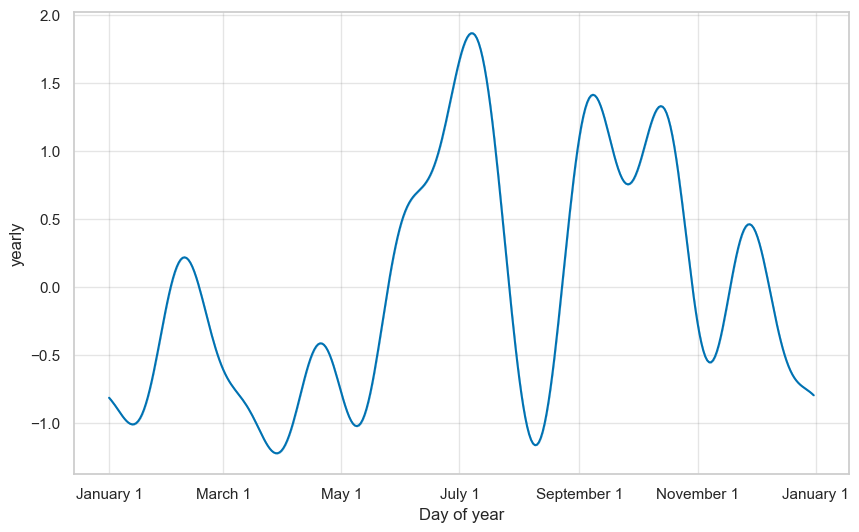

In [121]:
a = plot_yearly(m)

In [122]:
future = m.make_future_dataframe(periods=5, freq='D')
future.tail()

,ds
3231,2023-01-01
3232,2023-01-02
3233,2023-01-03
3234,2023-01-04
3235,2023-01-05


In [123]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2013-11-01,10.420197,5.010080,16.416243
1,2013-11-02,10.296150,4.555426,16.086026
2,2013-11-03,8.163489,2.631837,13.538422
3,2013-11-04,12.167258,6.755885,17.528221
4,2013-11-05,10.031375,4.375783,16.063853
...,...,...,...,...
3231,2023-01-01,5.173394,-0.712792,10.829863
3232,2023-01-02,9.221080,3.640454,14.831722
3233,2023-01-03,7.113810,1.412530,12.150289
3234,2023-01-04,6.432039,0.897398,12.048075


In [124]:
test

,ds,y
3231,2023-01-01,4
3232,2023-01-02,9
3233,2023-01-03,7
3234,2023-01-04,6
3235,2023-01-05,10


In [125]:
y_true = test['y']
y_pred = forecast['yhat'].tail()
mae = mean_absolute_error(y_true, y_pred)

MAE: 0.864


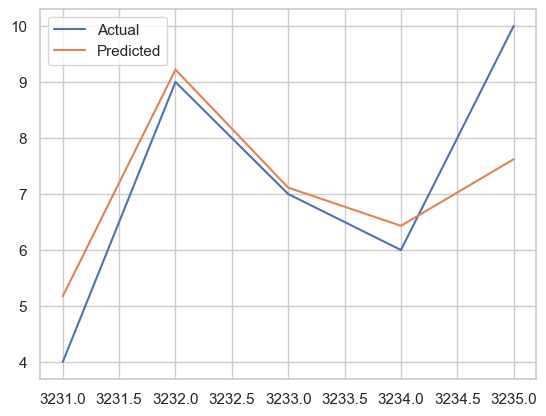

In [126]:
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

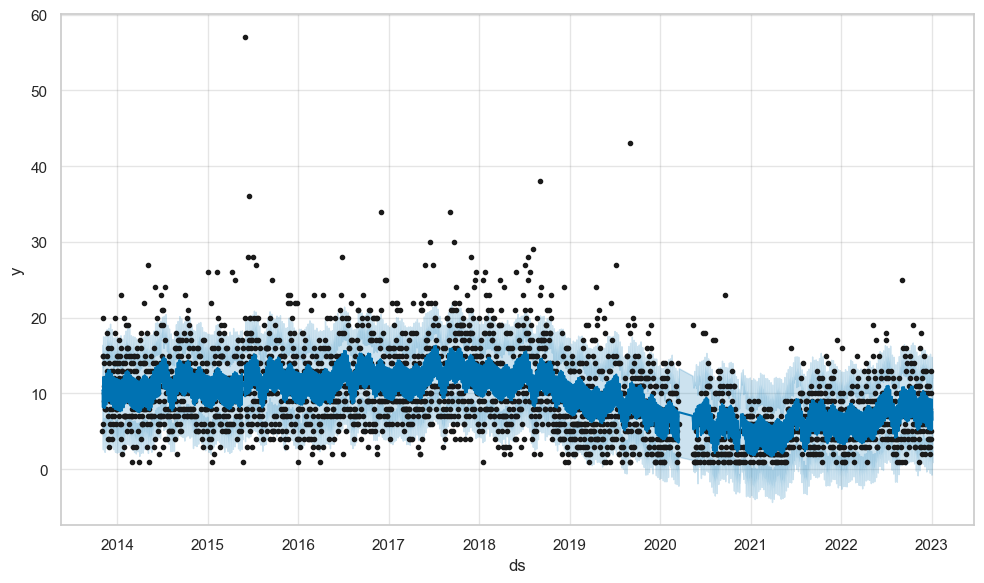

In [127]:
fig1 = m.plot(forecast, uncertainty=True)

In [128]:
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

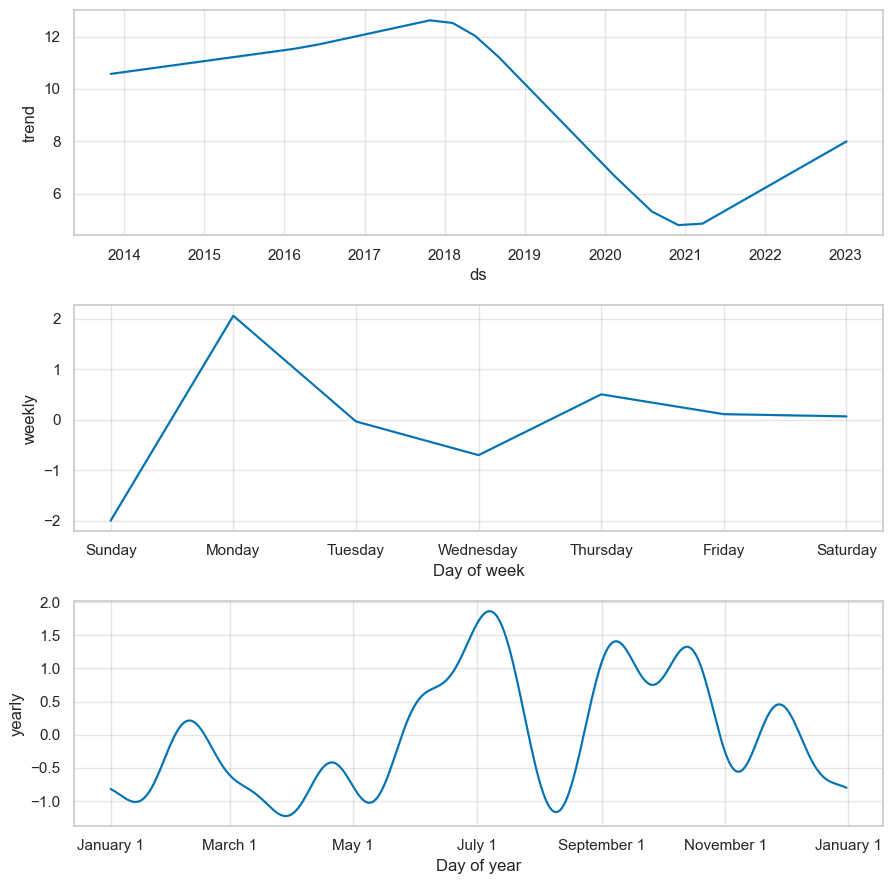

In [129]:
fig2 = m.plot_components(forecast)